Using Pretrained Model for Transfer Learning

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf


dataset, info = tfds.load("tf_flowers", split= [
    "train[:10%]", # test set
    "train[10%:25%]", # validation set
    "train[25%:]" # train set
], as_supervised= True, with_info= True)

test_set, valid_set, train_set = dataset
dataset_size = info.splits["train"].num_examples
dataset_size

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.WJEVCO_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


3670

In [4]:
dataset_classes = info.features["label"].names
dataset_classes

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [5]:
n_classes = info.features["label"].num_classes
n_classes

5

In [6]:
len(train_set)

2752

Preprocessing the Datasets to XCEPTION CNN Architecture

In [7]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# Tip <br>
add keras.preprocessing.image.ImageDataGenerator() for data augmentation

In [8]:
# apply preprocess, batch, and prefetch on the dataset
batch_size = 32
train_set = train_set.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
# load pretrained xception model excluding top layer
base_model = tf.keras.applications.xception.Xception(weights= "imagenet", include_top= False)
# create custome pooling and dense layer
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output) # specify pool_size
output = tf.keras.layers.Dense(n_classes, activation= "softmax")(avg)
# create the model
model = tf.keras.models.Model(inputs= base_model.input, outputs= output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# freezing pretrained layers at the beginning of training
for layer in base_model.layers:
    layer.trainable = False

In [11]:
model.layers[1].trainable

False

In [12]:
# compile model
optimizer = tf.keras.optimizers.SGD(learning_rate= 0.2, momentum= 0.9, decay= 0.01)
model.compile(loss= "sparse_categorical_crossentropy",
              optimizer= optimizer,
              metrics= ["accuracy"])
history = model.fit(train_set, epochs= 5, validation_data= valid_set)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 37s 263ms/step - accuracy: 0.7115 - loss: 1.5604 - val_accuracy: 0.7913 - val_loss: 1.4863
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.8758 - loss: 0.9648 - val_accuracy: 0.8348 - val_loss: 1.3469
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 205ms/step - accuracy: 0.8887 - loss: 0.8556 - val_accuracy: 0.8603 - val_loss: 1.4534
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.9331 - loss: 0.4525 - val_accuracy: 0.8149 - val_loss: 1.7379
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.9304 - loss: 0.4793 - val_accuracy: 0.8240 - val_loss: 1.6603


In [28]:
for layer in base_model.layers:
  layer.trainable = True

In [32]:
optimizer = tf.keras.optimizers.SGD(learning_rate= 0.2, momentum= 0.9, decay= 0.01)
model.compile(loss= "sparse_categorical_crossentropy",
              optimizer= optimizer,
              metrics= ["accuracy"])
history_2 = model.fit(train_set, epochs= 10, validation_data= valid_set)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 959ms/step - accuracy: 0.2733 - loss: 1.9265 - val_accuracy: 0.1996 - val_loss: 13663.9814
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 140s 936ms/step - accuracy: 0.3452 - loss: 1.4274 - val_accuracy: 0.2432 - val_loss: 6.2110
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 938ms/step - accuracy: 0.4114 - loss: 1.3276 - val_accuracy: 0.4428 - val_loss: 1.3400
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 79s 907ms/step - accuracy: 0.4787 - loss: 1.2782 - val_accuracy: 0.4229 - val_loss: 1.2846
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 80s 932ms/step - accuracy: 0.4958 - loss: 1.2168 - val_accuracy: 0.4592 - val_loss: 1.2667
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 80s 909ms/step - accuracy: 0.5293 - loss: 1.1446 - val_accuracy: 0.5118 - val_loss: 1.2045
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 81s 904ms/step - accuracy: 0.5496 - loss: 1.0871 - val_accuracy: 0.3811 - val_loss: 3.3597
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 85s 935ms/step - accuracy: 0.5781 - loss: 1.0306 - val_accuracy: 

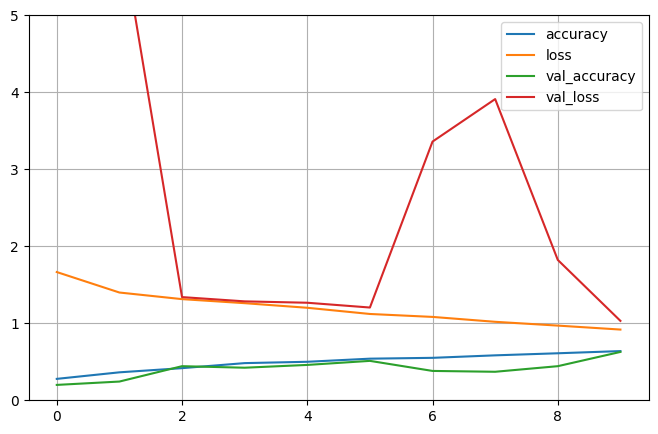

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

df = pd.DataFrame(history_2.history).plot(figsize= (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()